# Results for single settings

This notebook displays the results for each of the single settings introduced in the paper (same as done in section 6.1)

In [ ]:
import json
import re
from analysis import Analysis, guesser_vs_oracle_update, stepwise_guesser_annotations
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from collections import defaultdict 
from IPython.display import HTML
import ipywidgets as widgets
from IPython.display import display
import nltk

plt.rcParams.update({'font.size': 13})
sns.set_style("darkgrid")

## Load data

Select one setting from the following:

* **8_mcrae** *(8 candidates based on McRae feature norms)*

* **16_mcrae** *(16 candidates based on McRae feature norms)*

* **8_gpt** *(8 candidates based on ChatGPT's feature norms)*

* **8_wordnet** *(8 candidates based on WordNet taxonomy)*

* **8_mcrae_stepwise** *(8 candidates based on McRae feature norms + Modified Prompt for explicit HypSpace update)*

In [40]:
# modify setting here
setting = "8_mcrae"

In [41]:
with open(f"../data/generation/{setting}/dialogues.txt") as f:
     dialogues = f.read()  
with open(f"../data/generation/{setting}/oracle_annotations.json") as f:
     oracle_annotations = json.load(f)
if "stepwise" not in setting:
     with open(f"../data/generation/{setting}/guesser_annotations.json") as f:
          guesser_annotations = json.load(f)
else:
     guesser_annotations = stepwise_guesser_annotations(dialogues)
analysis = Analysis(dialogues, oracle_annotations, setting)

## Search Efficiency

### Average number of questions per game

In [42]:
avg_qs = analysis.average_questions()

df = pd.DataFrame(
    {
    "ChatGPT-Q" : [round(avg_qs, 2)],
    "Optimal" : [(np.log2(analysis.num_candidates)+0.5)],
    "Baseline": [(analysis.num_candidates/2)],
    }
)

HTML(df.to_html(index=False))

ChatGPT-Q,Optimal,Baseline
7.24,3.5,4.0


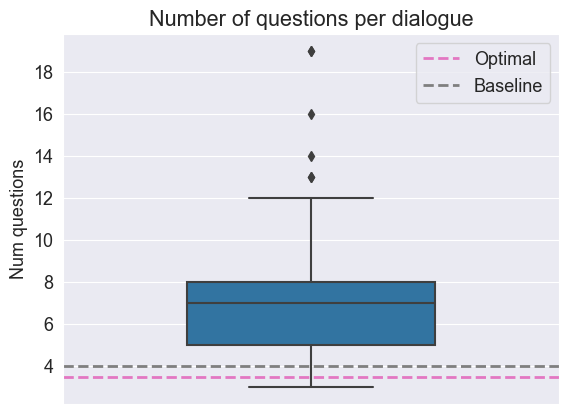

In [43]:
fig = sns.boxplot(analysis.questions_dist, width=0.5)
plt.title("Number of questions per dialogue")
plt.xticks([])
plt.ylabel("Num questions")
plt.axhline((np.log2(analysis.num_candidates)+0.5), color='tab:pink', linestyle='dashed', linewidth=2, label='Optimal')
plt.axhline((analysis.num_candidates/2), color='tab:gray', linestyle='dashed', linewidth=2, label="Baseline")
plt.legend()
plt.show(fig)

In [44]:
print(stats.wilcoxon(np.array(analysis.questions_dist) - (analysis.num_candidates/2)))

WilcoxonResult(statistic=16.0, pvalue=3.7390122324609796e-14)


##### Unnecessary questions

In [45]:
unnecessary_qs, percentage_unnecessary_dial, percentage_unnecessary_qs = analysis.unnecessary_questions()

print(f"Total number of UQ: {np.sum(unnecessary_qs)}\n")
print(f"% of games with at leats 1 UQ: {round(percentage_unnecessary_dial, 2)}\n")
print(f"% of UQ among all questions: {round(percentage_unnecessary_qs, 2)}")

Total number of UQ: 191

% of games with at leats 1 UQ: 56.67

% of UQ among all questions: 29.29


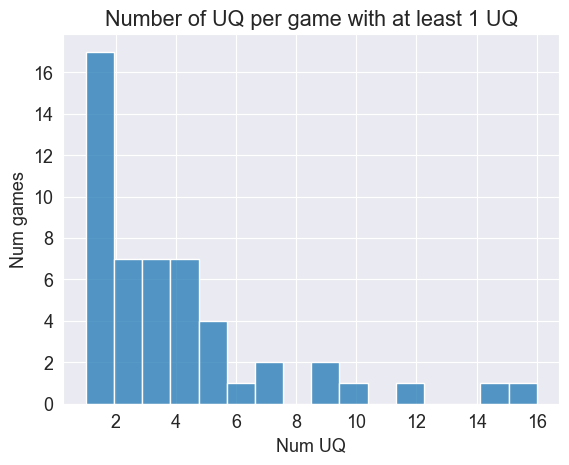

In [46]:
fig = sns.histplot(unnecessary_qs, bins=16)
plt.title("Number of UQ per game with at least 1 UQ")
plt.ylabel("Num games")
plt.xlabel("Num UQ")
plt.show(fig)

## Information-Seeking Strategy

### Type of questions

In [47]:
hypothesis_scanning, constraint_seeking, pseudo_constraint_seeking = analysis.questions_strategies()

df = pd.DataFrame(
    {
    "Type" : ["HS", "CS"],
    "ChatGPT-Q" : [round(hypothesis_scanning + pseudo_constraint_seeking, 2), round(constraint_seeking ,2)],
    "Optimal" : [round(1.5/(np.log2(analysis.num_candidates)+0.5)*100, 2), round((np.log2(analysis.num_candidates)-1)/(np.log2(analysis.num_candidates)+0.5)*100, 2)],
    "Baseline": [100.0, 0.0]
    }
)

HTML(df.to_html(index=False))

Type,ChatGPT-Q,Optimal,Baseline
HS,26.23,42.86,100.0
CS,73.77,57.14,0.0


In [48]:
df = pd.DataFrame(
    {
    "Type" : ["HS", "CS", "PCS"],
    "ChatGPT-Q" : [round(hypothesis_scanning, 2), round(constraint_seeking ,2), round(pseudo_constraint_seeking, 2)],
    "Optimal" : [round(1.5/(np.log2(analysis.num_candidates)+0.5)*100, 2), round((np.log2(analysis.num_candidates)-1)/(np.log2(analysis.num_candidates)+0.5)*100, 2), 0.0],
    "Baseline": [100.0, 0.0, 0.0]
    }
)

HTML(df.to_html(index=False))

Type,ChatGPT-Q,Optimal,Baseline
HS,17.79,42.86,100.0
CS,73.77,57.14,0.0
PCS,8.44,0.00,0.0


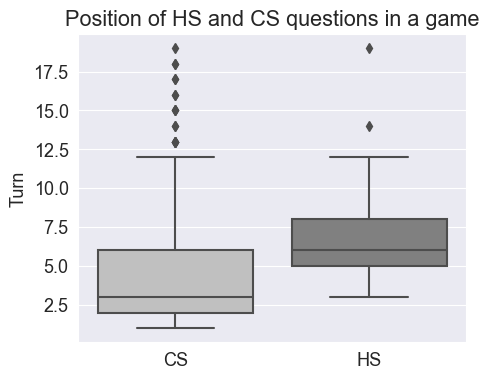

In [49]:
plt.figure(figsize=(5, 4))
sns.boxplot([analysis.cs_questions_pos, analysis.hs_questions_pos], palette=["silver","gray"])
plt.xticks([0, 1], ['CS', 'HS'])
plt.title("Position of HS and CS questions in a game")
plt.ylabel("Turn")
plt.show()

In [50]:
print(stats.mannwhitneyu(analysis.hs_questions_pos, analysis.cs_questions_pos))

MannwhitneyuResult(statistic=42645.0, pvalue=5.399384105091375e-19)


There is a significant difference between the position of HS and CS questions.

### EIG per turn

In [51]:
ig_per_turn = analysis.compute_eig()

eig_dict = {
    i : (i+1, round(np.mean(ig_per_turn["model"][i]),2), round(np.mean(ig_per_turn["optimal"][i]),2), round(np.mean(ig_per_turn["baseline"][i]),2)) 
    for i in range(round(avg_qs))
}

df = pd.DataFrame.from_dict(eig_dict, orient='index')
df = df.rename(columns={0: "Turn", 1 : "ChatGPT-Q", 2: "Optimal", 3: "Baseline"})

HTML(df.to_html(index=False))

Turn,ChatGPT-Q,Optimal,Baseline
1,0.94,1.00,0.54
2,0.59,0.99,0.79
3,0.59,0.84,0.77
4,0.36,0.61,0.59
5,0.27,0.46,0.45
6,0.13,0.29,0.29
7,0.13,0.21,0.21


<Axes: title={'center': 'EIG per turn'}, xlabel='Turn', ylabel='Average EIG'>

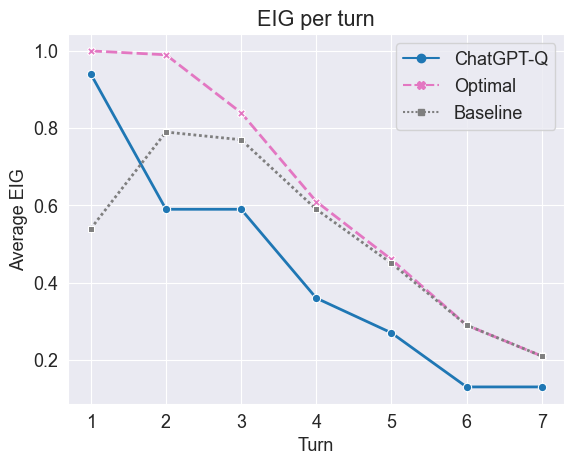

In [52]:
df = df.drop(columns=["Turn"])
df.index = range(1,(round(avg_qs)+1))
plt.title("EIG per turn")
plt.xlabel('Turn')
plt.ylabel('Average EIG')
palette = {"ChatGPT-Q":"tab:blue", "Optimal":"tab:pink", "Baseline":"tab:gray"}
sns.lineplot(df, markers=True, palette=palette, linewidth=2)

## Hypothesis Space update

In [53]:
correcteness, distance = guesser_vs_oracle_update(guesser_annotations, oracle_annotations)

df = pd.DataFrame(
    {
        "Turn" : range(1,(round(avg_qs)+1)), 
        "HypSpace Update Distance" : [np.mean(distance[i]) for i in range(1,(round(avg_qs)+1))]
    }
)

HTML(df.to_html(index=False))

Turn,HypSpace Update Distance
1,0.466667
2,1.188889
3,1.125000
4,1.693333
5,1.774194
6,1.595745
7,1.793103


## Error analysis

* ER = Error rate
* SP = % games with spoiler answers by oracle
* CQ = % contradictory questions across all games
* TQ = % trivial questions across all games

In [54]:
df = pd.DataFrame(
    {
        "ER" : [round(analysis.ans_error_rate(), 2)],
        "SP" : [round(analysis.oracle_spoilers(), 2)],
        "CQ" : [round(analysis.contradictory_questions(), 2)],
        "TQ" : [round(analysis.trivial_questions(), 2)]
    }
)

HTML(df.to_html(index=False))

ER,SP,CQ,TQ
12.22,12.22,13.5,25.15
